In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
from tapm import bigmodel_STI
import icomo
import numpy as np
import copy
from matplotlib.colors import LogNorm
from tapm import utils

ERROR:tapm.HIVandSTI.model_HIVandSTI:y_0 does not add up to 1 for HIV.
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


# TEST FOR MODEL : AND ITS WORKING

In [2]:

def compute_sti_infections(
    Hs, Ps, lambda_P_values, args, y0_in, filename=None
):
    """
    Compute STI infections for given H, P, and lambda_P values and store the results for different H values.

    Parameters:
    Hs (list): List of H values.
    Ps (list): List of P values.
    lambda_P_values (list): List of lambda_P values.
    y0 (dict): Initial state of the system.
    args (dict): Arguments for the model.
    integrator (function): Function to integrate the model.
    model_STI (module): Module containing STI model functions.
    filename (str): Name of the file to save the results.

    Returns:
    dict: Results for different H values.
    """
    # Dictionary to store results for different H values
    results = {}

    # Loop over each value of H
    for H in Hs:
        args_mod = args.copy()
        args_mod["H"] = H
        # Determine the size of the result matrices
        res_size = [len(lambda_P_values), len(Ps)]

        # Initialize result matrices
        res_Ia = np.zeros(res_size)  # Asymptomatic STI infections
        res_Is = np.zeros(res_size)  # Symptomatic STI infections
        res_T = np.zeros(res_size)  # Treated STI infections
        res_S = np.zeros(res_size)
        res_prevalance = np.zeros(res_size)  # Total infections
        check = np.zeros(res_size)  # Convergence check
        check_1 = np.zeros(res_size)

        # Loop over each lambda_P value
        for i, lambda_P in enumerate(lambda_P_values):
            for j, P in enumerate(Ps):
                args_mod["P"] = P
                args_mod["lambda_P"] = lambda_P

                #print(f"Running for H={H}, P={P}, lambda_P={lambda_P}, y0={y0_in}")
                
                output = icomo.diffeqsolve(
                    args = args_mod,
                    ODE = bigmodel_STI.main_model,
                    y0 = y0_in,
                    ts_out = np.linspace(0, 365*80, 365*80+1),
                    max_steps=365*80+1)
                
                # Get the final state of the system
                y1 = {key: value[-1] for key, value in output.ys.items()}
                y2 = {key: value[-5] for key, value in output.ys.items()}
                #check convergence by comparing last value to fifth last value
                #for key in y1:
                #    if not np.allclose(y1[key], y2[key], rtol=0, atol=1e-8):
                #        print(f"Convergence failed: P: {P}, H: {H}, {key}: (diff = {abs(y1[key] - y2[key])})")
                
                # Record the final susceptible individuals
                res_S[i, j] = jnp.sum(y1["S_STI"])

                # Record the final asymptomatic STI infections
                res_Ia[i, j] = jnp.sum(y1["Ia_STI"])

                # Record the final symptomatic STI infections
                res_Is[i, j] = jnp.sum(y1["Is_STI"])

                # Record the final treated STI infections
                res_T[i, j] = jnp.sum(y1["T_STI"])


                # Calculate total new infections
                res_prevalance[i, j] = res_Ia[i, j] + res_Is[i, j] 


                check_1[i, j] = res_S[i, j] + res_Ia[i, j] + res_Is[i, j] + res_T[i, j] 
                # if abs(check_1[i, j] - 1) > 1e-8:
                #     print(f"Population did not stay constant (H = {H}, P = {P}, sum = {check_1[i, j]})")


        # Store the results for the current H value
        results[H] = {
            "res_S": res_S,
            "res_Ia": res_Ia,
            "res_Is": res_Is,
            "res_T": res_T,
            "res_infections": res_prevalance,
            "check": check,
            "check_1": check_1,
        }


    # Save the results to a file
    
    
    #if filename:
    #    utils.save_results(results, filename)

    return results



# Define the parameters
Hs = np.linspace(0.0, 0.2, 101)
Ps = np.linspace(0, 1, 201)
lambda_P_values = np.array([1.0, 2.0, 4.0]) / 365.0
args = bigmodel_STI.args
result_prevalance = compute_sti_infections(Hs, Ps, lambda_P_values, args, bigmodel_STI.y0, filename=None)
utils.save_results(result_prevalance, filename="result_for_fig_1_bigSTImodel")

INFO:tapm.HIVandSTI.bigmodel_STI:Using exponential function to calculate m
INFO:tapm.HIVandSTI.bigmodel_STI:Parameters: m_min = 0.0, m_max = 1
INFO:tapm.utils:Results saved to ../results/result_for_fig_1_bigSTImodel.npy


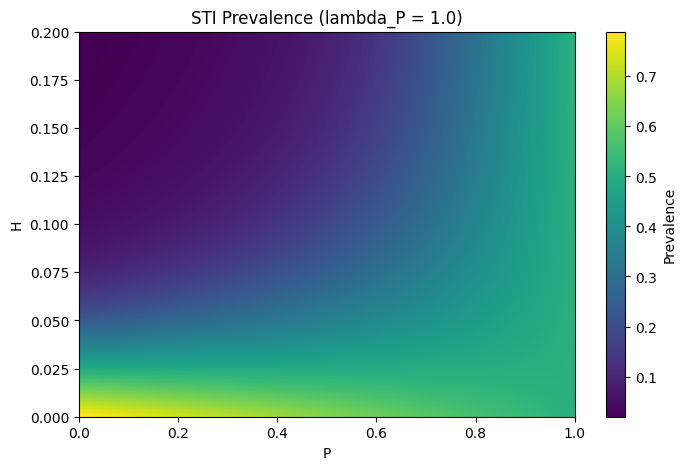

In [3]:

# Select the index of lambda_P_values
lambda_P_idx = 0

# Create a prevalence matrix for heatmap: rows=Hs, columns=Ps
prevalence_matrix = np.zeros((len(Hs), len(Ps)))

for i, H in enumerate(Hs):
    # Each H value is used as a key, we take only the desired lambda_P index row
    prevalence_matrix[i, :] = result_prevalance[H]["res_infections"][lambda_P_idx,:]

plt.figure(figsize=(8, 5))
im = plt.imshow(
    prevalence_matrix, 
    aspect='auto',
    extent=[Ps[0], Ps[-1], Hs[0], Hs[-1]],    # Y axis = H from low to high
    origin='lower',                           # H increases upward (lower = H[0])
    cmap='viridis',
    #vmax = 0.7
    #norm=LogNorm(vmin=prevalence_matrix.min(), vmax=prevalence_matrix.max())
)
plt.colorbar(im, label='Prevalence')
plt.xlabel("P")
plt.ylabel("H")
plt.title(f"STI Prevalence (lambda_P = {lambda_P_values[lambda_P_idx]*365})")
plt.show()

# Final Figure 1

## Data generation

In [2]:
def compute_sti_infections_grid(
    Hs, Ps, lambda_P_values, beta_STI_values, args, y0_in, filename=None
):
    """
    Computes and saves results as: results[(beta_STI, lambda_P)] = (len(Hs), len(Ps)) array of res_infections
    """
    import numpy as np

    results = {}
    for beta_STI in beta_STI_values:
        args_base = args.copy()
        args_base["beta_STI"] = beta_STI
        for i_lambda, lambda_P in enumerate(lambda_P_values):
            res_prevalence = np.zeros((len(Hs), len(Ps)))
            for i_H, H in enumerate(Hs):
                args_mod = args_base.copy()
                args_mod["H"] = H
                args_mod["lambda_P"] = lambda_P
                for j_P, P in enumerate(Ps):
                    args_mod["P"] = P
                    
                    output = icomo.diffeqsolve(
                        args=args_mod,
                        ODE=bigmodel_STI.main_model,
                        y0=y0_in,
                        ts_out=np.linspace(0, 365*80, 365*80+1),
                        max_steps=365*80+1
                    )
                    y1 = {key: value[-1] for key, value in output.ys.items()}
                    Ia = np.sum(y1["Ia_STI"])
                    Is = np.sum(y1["Is_STI"])
                    res_prevalence[i_H, j_P] = Ia + Is
            results[(beta_STI, lambda_P)] = res_prevalence

    # Optionally save
    if filename:
        from tapm import utils
        utils.save_results(results, filename)

    return results

In [3]:
# Define the parameter sets as before
Hs = np.linspace(0.0, 0.2, 51)
Ps = np.linspace(0, 1, 101)
lambda_P_values = np.array([1.0, 2.0, 4.0]) / 365.0
beta_STI_values = [0.0016 * 5.0, 0.0016 * 7.0]

args = bigmodel_STI.args
y0 = bigmodel_STI.y0

results = compute_sti_infections_grid(Hs, Ps, lambda_P_values, beta_STI_values, args, y0, filename="result_for_fig_1_bigSTImodel_c7")

INFO:tapm.HIVandSTI.bigmodel_STI:Using exponential function to calculate m


INFO:tapm.HIVandSTI.bigmodel_STI:Parameters: m_min = 0.0, m_max = 1
INFO:tapm.utils:Results saved to ../results/result_for_fig_1_bigSTImodel_c7.npy


## Figure 1

In [8]:
results = utils.load_results("result_for_fig_1_bigSTImodel_c5")

INFO:tapm.utils:Results loaded from ../results/result_for_fig_1_bigSTImodel_c5.npy


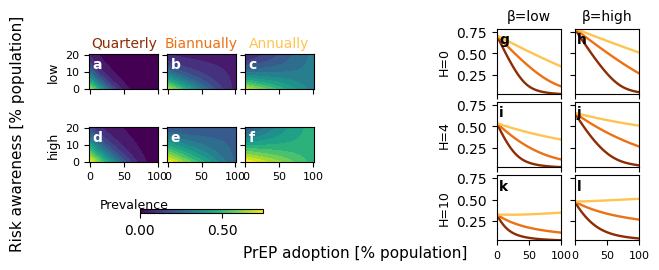

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec


def discretize_cmaps(cmap, N):
    cmap = plt.colormaps.get_cmap(cmap)
    colors = cmap(np.linspace(0, 1, N))
    res = ListedColormap(colors)
    res.set_bad("#ABABAB")
    return res


# ==== DATA: You must supply these as before ====
beta_STI_values = [0.0016 * 5.0, 0.0016 * 7.0]
beta_STI_labels = ["low",  "high"]
lambda_P_values = [4/365.0, 2/365.0, 1/365.0]
lambda_P_labels = ["Quarterly", "Biannually", "Annually"]
colors_R0 = ["#8c2d04", "#ec7014", "#fec44f"]
num_Hs = 51
num_Ps = 101
Hs = np.linspace(0, 0.2, num_Hs)
Ps = np.linspace(0, 1.0, num_Ps)
fixed_H_indexes = [0, 10, int(len(Hs)*0.5)]

# Find global min/max for color scaling
allvals = np.concatenate([results[(beta, lam)].flatten() for beta in beta_STI_values for lam in lambda_P_values])
global_vmin = np.nanmin(allvals)
global_vmax = np.nanmax(allvals)

cmap_disc = discretize_cmaps("viridis", 15)
norm = BoundaryNorm(np.linspace(global_vmin, global_vmax, cmap_disc.N), cmap_disc.N)

# ============= FIGURE LAYOUT ==============

# Panel sizes in inches (from pt)
left_w = 62.5/72.0
left_h = 37.8/72.0
right_w = 64/72.0
right_h = 43.8/72.0
hpad = 0.48  # horizontal pad between columns
vpad = 0.28  # vertical pad between rows
center_pad = 0.09  # between left and right grid

# Figure size
fig_width = 3*left_w + 2*hpad + center_pad + 2*right_w + hpad
fig_height = max(2*left_h + vpad, 3*right_h + 2*vpad) + 0.18  # extra for colorbar

fig = plt.figure(figsize=(7.09, 2.75))

# OUTER gridspec (2 columns: left and right)
outer_gs = GridSpec(1, 2, width_ratios=[3*left_w+2*hpad, 2*right_w+hpad], wspace=center_pad/(fig_width - (3*left_w+2*hpad + 2*right_w+hpad)), figure=fig)

# LEFT inner grid: 2 rows x 3 columns
from matplotlib.gridspec import GridSpecFromSubplotSpec
left_gs = GridSpecFromSubplotSpec(
    2, 3,
    subplot_spec=outer_gs[0],
    width_ratios=[left_w, left_w, left_w],
    height_ratios=[left_h, left_h],
    wspace=hpad/(3*left_w+2*hpad),
    hspace=vpad/(2*left_h+vpad)
)
# right_gs
right_gs = GridSpecFromSubplotSpec(
    3, 2,
    subplot_spec=outer_gs[1],
    width_ratios=[right_w, right_w],
    height_ratios=[right_h, right_h, right_h],
    wspace=hpad/(2*right_w+hpad),
    hspace=vpad/(3*right_h+2*vpad)
)

axes_left = [fig.add_subplot(left_gs[i, j]) for i in range(2) for j in range(3)]
axes_right = [fig.add_subplot(right_gs[i, j]) for i in range(3) for j in range(2)]

# ==== LEFT PANEL: Heatmaps ====
for row_idx, beta_STI in enumerate(beta_STI_values):
    for col_idx, (lambda_P, label) in enumerate(zip(lambda_P_values, lambda_P_labels)):
        ax = axes_left[row_idx*3 + col_idx]
        res_infections = np.clip(results[(beta_STI, lambda_P)], a_min=0, a_max=None)
        im = ax.imshow(res_infections, origin="lower", cmap=cmap_disc, 
                       vmin=global_vmin, vmax=global_vmax, interpolation="bicubic")

        if row_idx == 0:
            ax.set_title(label, fontsize=10, pad=5, color=colors_R0[col_idx])
        if col_idx == 0:
            ax.set_ylabel(beta_STI_labels[row_idx], fontsize=9)

        if row_idx == 1:
            ax.set_xticks([0, (num_Ps-1)//2, (num_Ps-1)])
            ax.set_xticklabels(
                [int(Ps[0] * 100), int(Ps[(num_Ps-1)//2] * 100), int(Ps[(num_Ps-1)] * 100)], fontsize=8)
        else:
            ax.set_xticks([0, (num_Ps-1)//2, (num_Ps-1)])
            ax.set_xticklabels([])

        if col_idx == 0:
            ax.set_yticks([0, (num_Hs-1)//2, (num_Hs-1)])
            ax.set_yticklabels([int(Hs[0] * 100), int(Hs[num_Hs//2] * 100), int(Hs[(num_Hs-1)] * 100)], fontsize=8)
        else:
            ax.set_yticks([0, (num_Hs-1)//2, (num_Hs-1)])
            ax.set_yticklabels([])
        # ax.tick_params(axis='both', which='both', length=0)
        ax.grid(False)

# Colorbar below the left grid (spans all six axes)
orig_cmap = plt.get_cmap('viridis')
colors = orig_cmap(np.linspace(0,1,256))
colors[0] = [0,0,0,1]  # Black at the start
new_cmap = mcolors.ListedColormap(colors)
sm = mpl.cm.ScalarMappable(cmap=new_cmap, norm=mpl.colors.Normalize(vmin=0, vmax=0.75))
sm.set_array([])
cbar = fig.colorbar(sm,
                   ax=axes_left,
                   shrink=0.55, 
                   location='bottom',
                   aspect=27,
                   pad=0.22,
                   format=FuncFormatter(lambda x, pos: f"{x:.2f}"))
cbar.ax.set_ylabel("Prevalence", fontsize=9, rotation=0)

# ==== RIGHT PANEL: 3x2 line plots ====
for i, H_index in enumerate(fixed_H_indexes):
    for j, beta_STI in enumerate(beta_STI_values):
        ax = axes_right[i*2 + j]
        for k, lambda_P in enumerate(lambda_P_values):
            data = results[(beta_STI, lambda_P)]
            Y = data[H_index, :]
            ax.plot(Ps, Y, color=colors_R0[k], linewidth=1.7, label=lambda_P_labels[k] if i == 0 else None)
        if i != 2:
            ax.set_xticklabels([])
        else:
            ax.set_xticks([0, 0.5, 1.0])
            ax.set_xticklabels(['0', '50', '100'], fontsize=8)
            # ax.set_xlabel('PrEP adoption [% population]', fontsize=9)
        if j == 0:
            ax.set_ylabel(f'H={Hs[H_index]*100:.0f}', fontsize=9)
        else:
            ax.set_yticklabels([])

        ax.set_xlim(Ps.min(), Ps.max())
        ax.set_ylim(global_vmin, global_vmax)
        if i == 0:
            ax.set_title(f'β={beta_STI_labels[j]}', fontsize=10)
        # ax.tick_params(axis='both', which='both', length=0)
        ax.grid(False)
        # legend for only the first panel
        # if i==0 and j==0:
        #     ax.legend(fontsize=7, loc='upper right', frameon=True, framealpha=1)

# Add letters a-f
for idx, ax in enumerate(axes_left):
    ax.text(0.05, 0.92, chr(97 + idx), transform=ax.transAxes,
            fontsize=10, fontweight="bold", va="top", ha="left", color="white")

# Add letters g-l
letters2 = ["g","h","i","j","k","l"]
for idx, ax in enumerate(axes_right):
    ax.text(0.035, 0.94, letters2[idx], transform=ax.transAxes,
            fontsize=10, fontweight="bold", va="top", ha="left")

# Main axis labels
fig.text(0.5, 0.05, "PrEP adoption [% population]", ha="center", fontsize=11)
fig.text(0.013, 0.5, "Risk awareness [% population]", va="center", rotation="vertical", fontsize=11)

plt.show()
# Save the figure
# fig.savefig("figure_1_bigSTImodel_c5.pdf", dpi=300, bbox_inches='tight')